# Apartment Model Example

The following example illustrates this method.  The method requires a linear algebra library:

In [1304]:
import numpy as np
from numpy import linalg as LA
def prfloat(x,n=10,m=4,f="g"):
    if x == 0.0:
        return " "*(n-1) + "0"
    else:
        return f"%{n}.{m}f"%x
def DUMP(_a,_b=None):
    if _b == None: 
        _t = str(eval(_a))
        if _t.find('\n') > 0:
            print(f"{_a} = \n{_t}")
        else:
            print(f"{_a} = {eval(_a)}")
    else:
        _t = str(eval(_b))
        if _t.find('\n') > 0:
            print(f"{_b} = # {_a}\n{_t}")
        else:
            print(f"{_b} = {eval(_b)} # {_a}")
np.set_printoptions(precision=4,floatmode='fixed',formatter={'float':lambda x: prfloat(x,10,4,"f")})

The outdoor temperature is assumed to be 20F below the indoor setpoint.

The building has the following characteristics

In [1305]:
# Table 3: Building design parameters
N = 1 # 10 floors
M = 2 # 20 units per floor
X = 24 # unit width (ft)
Y = 40 # unit depth (ft)
Z = 8 # unit height (ft)
W = 6 # corridor width (ft)
F = 1 # floor thickness (ft)
I = 1 # Wall thickness (ft)

Kx = 0 # corridor is not exterior
Kd = 1 # corridor is double-sided
omega = 0.5 # exterior window/wall ratio
beta = 0.95 # fraction of units that are occupied
a = 0.9 # fraction of heat gain that goes to zone instead of mass
b = 1-a # fraction of heat gain that is taken up directly by mass





In [1306]:
# Table 5: Derived building properties
A = X*Y # unit floor area (sf)
Ad = 3*6.7 # unit door area (sf)
Aw_unit = omega*X*Z # unit window area (sf)
Aw_core = omega*W*Z # core window area (sf)
Au = Y*Z # unit-unit wall area (sf)
Ao = X*Z - Aw_unit # unit-outdoor wall area (sf)
Ac = X*Z - Ad # unit-core wall area (sf)
Ah = W*Z # Core exterior wall ares (sf)
Ah_w = Ah - Aw_core # Core exterior wall with window (sf)
Ah_d = Ah - Ad # Core exterior wall with door (sf)


# components
Xl = M * X * (1 - .5 * Kd)
Al = Xl * Z
Ac_sides = 2*Ah*(1-Kx) # ??? Ah may not include window or door
Ac_aptwall = N*Al*(Kd+1) # ??? do you include doors
Ac_external = N*Al*(1-Kx)*(1-Kd)
Ac_floor = N*Xl*W
Ac_ceiling = N*Xl*W



In [1307]:
# Table 4: Building thermal properties
R_ext = 19
R_int = 5
R_window = 2
R_door = 3
R_mass = 1.41
R_floor = 1
R_roof = 60
R_ground = 60

R_C_window = (Ah_w/R_ext)+(Aw_core/R_window)
R_C_door = (Ah_d/R_ext)+(Ad/R_door)

In [1308]:
C_int = 2000 # occupied unit interior thermal capacitance (Btu/degF)

Sint = 10.0
Sfloor = 150.0

c_building = .3 # specific heat of wood (hardwood) (Btu/lbm.F)
rho_material = 45 # density of wood (hardwood) (lbm/cf)
rhoair = 0.0735




Sair = 0.2402*rhoair
Cint = Sint*A

In [1309]:
# Table 5: Derived building properties
V = X*Y*Z # unit volume (cf)
V_outsidewalls = 2*N*I*(Al+Au*(Kd+1)+Ah*(Kx-1))
V_innerwalls = N*I*(M-1-Kd)*Au
V_unitfloors = N*A*F
V_unitceiling = A*F
V_corewalls = N*Al*I*(2*Kd+(1-Kd)*(1-Kx))
V_corefloor = N*Xl*W*F
V_coreceiling = Xl*W*F


V_totalwalls = V_outsidewalls + V_innerwalls + V_unitfloors + V_unitceiling +V_corewalls + V_corefloor  +V_coreceiling 


In [1310]:
# set zone heat gains
Q_Rad_A = 0 # solar gains to occupied apartments (computed from weather data)
Q_Vent_A = 0 # ventilation gains to occupied apartments (computed from weather data)
Q_Enduse_A = 0 # electric load gains to occupied aparments (computed from equipment data)

Q_Rad_U = (1-beta)*Q_Rad_A # solar gains to unoccupied apartments (computed from weather data)
Q_Vent_U = 0 # ventilation gains to occupied apartments (computed from weather data)

Q_Rad_C = 0 # solar gains to core spaces (computed from weather data)
Q_Vent_C = 0 # ventilation gains to core spaces (computed from weather data)
Q_Enduse_C = 0 # electric load gains to core spaces (computed from equipment data)

Q_Gains_A = Q_Rad_A + Q_Vent_A + Q_Enduse_A
Q_Gains_U = Q_Rad_U + Q_Vent_U 
Q_Gains_C = Q_Rad_C + Q_Vent_C + Q_Enduse_C
Q_Gains_M = 0


In [1311]:
# set outdoor temperature (delta from T_A and T_M)
T_O = 100 # computed from weather data relative the apartment setpoint (e.g., T_A = 40 degF - T_O)
unit_temperature = 40
vacant_temperature = 50
core_temperature = 60
mass_temperature = 70
building_setpoint_temp = 70
unit_mode = 0
vacant_mode = 0
core_mode = 0

In [1312]:
# Building mode
m = np.sign(building_setpoint_temp - T_O) # -1 for cooling, +1 for heating

The HVAC system capabilities are

In [1313]:
# set heat/cool constraints
u_min = np.array([[-500000],[-200000],[-100000],[0]])
u_max = np.array([[500000],[200000],[150000],[0]])
# plant efficiency
e_cool = 3.0
e_heat = 4.0
# temperature setpoints
T_unoccupied = 10 # unoccupied zone temperature setpoint offset (degF)
T_core = 5 # core zone temperature setpoint offset (degF)

In [1314]:
DUMP("number of floors","N")
DUMP("number of units per floor","M")
DUMP("unit width (ft)","X")
DUMP("unit depth (ft)","Y")
DUMP("unit height (ft)","Z")
DUMP("core width (ft)","W")
DUMP("unit floor area (sf)","A")
DUMP("unit window area (sf)","Aw_unit")
DUMP("unit door area (sf)","Ad")
DUMP("unit wall area (sf)","Au")
DUMP("unit exterior wall area (sf)","Ao")
DUMP("unit core wall area (sf)","Ac")
DUMP("unit volume (cf)","V")
DUMP("occupancy factor (pu)","beta")
DUMP("indoor core fraction (pu)","Kx")
DUMP("indoor core double loading fraction (pu)","Kd")
DUMP("floor thickness (ft)","F")
DUMP("volumetric air density (lb/cf)","rhoair")
DUMP("air specific heat capacity (Btu/degF/cf)","Sair")
DUMP("interior mass loading (Btu/degF/sf)","Sint")
DUMP("interior heat capacity (Btu/degF)","Cint")
DUMP("density of floor mass (lb/cf)","Sfloor")

N = 1 # number of floors
M = 2 # number of units per floor
X = 24 # unit width (ft)
Y = 40 # unit depth (ft)
Z = 8 # unit height (ft)
W = 6 # core width (ft)
A = 960 # unit floor area (sf)
Aw_unit = 96.0 # unit window area (sf)
Ad = 20.1 # unit door area (sf)
Au = 320 # unit wall area (sf)
Ao = 96.0 # unit exterior wall area (sf)
Ac = 171.9 # unit core wall area (sf)
V = 7680 # unit volume (cf)
beta = 0.95 # occupancy factor (pu)
Kx = 0 # indoor core fraction (pu)
Kd = 1 # indoor core double loading fraction (pu)
F = 1 # floor thickness (ft)
rhoair = 0.0735 # volumetric air density (lb/cf)
Sair = 0.0176547 # air specific heat capacity (Btu/degF/cf)
Sint = 10.0 # interior mass loading (Btu/degF/sf)
Cint = 9600.0 # interior heat capacity (Btu/degF)
Sfloor = 150.0 # density of floor mass (lb/cf)


In [1315]:
# Table 6: Conductance calculations
U_OA_windowwall = N * M * beta * ((Ao/R_ext)+(Aw_unit))
U_OU_windowwall = ((1-beta)/beta) * U_OA_windowwall
U_OA_sidewall = 2*N*beta*(1+Kd)*(Au/R_ext)
U_OU_sidewall = ((1-beta)/beta) * U_OA_sidewall
U_OA_roof = M*beta*(A/(R_floor+R_roof))
U_OU_roof = ((1-beta)/beta) * U_OA_roof
U_OA_floor = M*beta*(A/(R_floor+R_ground))
U_OU_floor = ((1-beta)/beta) * U_OA_floor
U_UA_innerwalls = 2*N*M*beta*(1-beta)*(Au/R_int)
U_UA_floor = (N-1)*beta*M*(1-beta)*(A/R_floor)
U_UA_ceiling = (N-1)*beta*M*(1-beta)*(A/R_floor)
U_AU_floor = U_UA_ceiling
U_UA_ceiling = U_UA_floor
U_OC_sides = 2*N*(1-Kx)*(R_C_window+R_C_door)
U_OC_wall = (Al/R_ext)*(1-Kd)
U_OC_floor = Al/(R_floor+R_ground)
U_OC_roof = Al/(R_floor+R_roof)

In [1316]:
# Occupied Apartment
U_OA = U_OA_windowwall + U_OA_sidewall + U_OA_floor + U_OA_roof
U_UA = U_UA_innerwalls + U_UA_floor + U_UA_ceiling
U_CA = N*M*beta*((Ac/((1-Kx)*R_int+Kx*R_ext)+(Ad/R_door)))
U_MA = N*M*beta*((2*(A+Au)+Ao+Ac)/R_mass)

# Unoccupied Apartment
U_OU = U_OU_windowwall + U_OU_sidewall + U_OU_floor + U_OU_roof
U_UA = U_UA
U_UC = ((1-beta)/beta)*U_CA
U_MU = ((1-beta)/beta)*U_MA

# Building Core
U_OC = U_OC_sides + U_OC_wall + U_OC_floor + U_OC_roof
U_CA = U_CA
U_UC = U_UC
U_MC = (Ac_sides + Ac_aptwall + Ac_external + Ac_floor + Ac_ceiling)/R_mass

# Building Mass
U_OM = (2*N*(Al*(1+Kx)+Au*(1+Kd)+Ah*(1-Kx)+W*Xl*Kx))/R_mass
U_MA = U_MA
U_MU = U_MU
U_MC = U_MC


print("Table 6: Conductance calculations (kBtu/degF.h)\n\n" + 
      "U_OA U_UA U_CA U_MA U_OU U_UA U_UC U_MU U_OC U_CA U_UC U_MC U_OM U_MA U_MU U_MC \n" +
      "---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----\n" +
      "%4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f" 
      % (U_OA/1000,U_UA/1000,U_CA/1000,U_MA/1000,
      U_OU/1000,U_UA/1000,U_UC/1000,U_MU/1000,
      U_OC/1000,U_CA/1000,U_UC/1000,U_MC/1000,
      U_OM/1000,U_MA/1000,U_MU/1000,U_MC/1000))

Table 6: Conductance calculations (kBtu/degF.h)

U_OA U_UA U_CA U_MA U_OU U_UA U_UC U_MU U_OC U_CA U_UC U_MC U_OM U_MA U_MU U_MC 
---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----
   0    0    0    4    0    0    0    0    0    0    0    1    1    4    0    1


In [1317]:
DUMP("UA outdoor occupied (Btu/degF/h)","U_OA")


U_OA = 315.80327868852464 # UA outdoor occupied (Btu/degF/h)


In [1318]:
# Table 7: Capacitance calculations
C_A = N * M * beta * V * Sair
C_U = N * M * (1-beta) * V * Sair
C_C = N * Xl * Ah * Sair
C_M = V_totalwalls * rho_material * c_building + N * M * Cint

print("Table 7: Capacitance calculations (kBtu/degF)\n\n"
     + "C_A  C_U  C_C  C_M\n"
     + "---- ---- ---- ----\n"
     + "%4.0f %4.0f %4.0f %4.0f"
     % (C_A/1000,C_U/1000,C_C/1000,C_M/1000))

Table 7: Capacitance calculations (kBtu/degF)

C_A  C_U  C_C  C_M
---- ---- ---- ----
   0    0    0   75


In [1319]:
# DUMP("occupied zone heat capacity (Btu/degF)","C_A")
# DUMP("unoccupied zone heat capacity (Btu/degF)","C_U")
# DUMP("core zone heat capacity (Btu/degF)","C_C")
# DUMP("mass heat capacity (Btu/degF)","C_M")
# DUMP("occupied zone solar gain","Q_Rad_A")
# DUMP("occupied zone ventilation gain","Q_AV")
# DUMP("occupied zone equipment gain","Q_AE")
# DUMP("unoccupied zone solar gain","Q_US")
# DUMP("core zone solar gain","Q_CS")
# DUMP("core zone ventilation gain","Q_CV")

In [1320]:
# Thermal conditions
q = np.array([[Q_Gains_A], [Q_Gains_U], [Q_Gains_C], [Q_Gains_M] ,[T_O]])
print("Thermal conditions\n\n"
     + " Q_A  Q_U  Q_C Q_M  T_O \n"
     + "       kBtu/h      degF\n"
     + "---- ---- ---- ---- ----")
print("%4.0f %4.0f %4.0f %4.0f %4.0f"
     % (q[0]/1000,q[1]/1000,q[2]/1000,q[3]/1000,q[4]))

Thermal conditions

 Q_A  Q_U  Q_C Q_M  T_O 
       kBtu/h      degF
---- ---- ---- ---- ----
   0    0    0    0  100


In [1321]:

# compute the solution matrices
A = np.array([ 
      [-(U_OA+U_UA+U_CA+U_MA)/C_A,                   U_UA/C_A,                   U_CA/C_A,                   U_MA/C_A],
      [                  U_UA/C_U, -(U_OU+U_UA+U_UC+U_MU)/C_U,                   U_UC/C_U,                   U_MU/C_U],
      [                  U_CA/C_C,                   U_UC/C_C, -(U_OC+U_CA+U_UC+U_MC)/C_C,                   U_MC/C_C],
      [                  U_MA/C_M,                   U_MU/C_M,                   U_MC/C_M, -(U_OM+U_MA+U_MU+U_MC)/C_M]
    ])
DUMP("A")

A = 
[[  -16.3679     0.0472     0.3030    14.7919]
 [    0.8968   -17.2176     0.3030    14.7919]
 [    3.8377     0.2020   -33.2379    26.7812]
 [    0.0506     0.0027     0.0072    -0.0770]]


In [1322]:

B1 = np.array([ 
       [  a/C_A,     0,     0, 0, U_OA/C_A],
       [      0, a/C_U,     0, 0, U_OU/C_U],
       [      0,     0, a/C_C, 0, U_OC/C_C],
       [  b/C_M, b/C_M, b/C_M, 1, U_OM/C_M]
      ])
DUMP("B1")

B1 = 
[[    0.0035          0          0          0     1.2259]
 [         0     0.0664          0          0     1.2259]
 [         0          0     0.0443          0     2.4170]
 [    0.0000     0.0000     0.0000     1.0000     0.0166]]


In [1323]:
B2 = np.array([ 
       [ a/C_A,     0,     0, 0],
       [     0, a/C_U,     0, 0],
       [     0,     0, a/C_C, 0],
       [ b/C_M, b/C_M, b/C_M, 1]
      ])
DUMP("B2")

B2 = 
[[    0.0035          0          0          0]
 [         0     0.0664          0          0]
 [         0          0     0.0443          0]
 [    0.0000     0.0000     0.0000     1.0000]]


In [1324]:
_a = np.array([
    [1,2,-1],
    [1,0,1],
    [4,-4,5]])
_x0 = np.array([-1,0,0]).transpose()

_a_eigvals, _a_eigvects = LA.eig(_a)
t=0
print(_a_eigvals)
print(_a_eigvects)
_A = np.diag(np.exp(_a_eigvals * t))
print(_A)
_X =  _a_eigvects @ _A  
print('V times A',_X)

_c = LA.inv(_X) @ _x0
print(_c)

[    3.0000     2.0000     1.0000]
[[   -0.2357     0.4364     0.4082]
 [    0.2357    -0.2182    -0.4082]
 [    0.9428    -0.8729    -0.8165]]
[[    1.0000          0          0]
 [         0     1.0000          0]
 [         0          0     1.0000]]
V times A [[   -0.2357     0.4364     0.4082]
 [    0.2357    -0.2182    -0.4082]
 [    0.9428    -0.8729    -0.8165]]
[   -4.2426    -4.5826    -0.0000]


In [1325]:
T = np.array([[unit_temperature],[vacant_temperature],[core_temperature],[mass_temperature]])
Ainv = LA.inv(A)

s = B1@q
DUMP('B1')
# DUMP('q')
DUMP('s')

T_eq = -Ainv @ B1 @ q 
DUMP('Ainv')
DUMP("T_eq")
dT = A @ T_eq + B1 @ q
T_set = building_setpoint_temp - m * np.array([[0],[T_unoccupied],[T_core],[0]])
print("Temperatures (degF)\n\n"
     + "Zone   T(0) dT/dt  Teq   Set \n"
     + "----- ----- ----- ----- -----")
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_A',T[0],dT[0],T[0]+T_eq[0],T_set[0]))
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_U',T[1],dT[1],T[0]+T_eq[1],T_set[1]))
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_C',T[2],dT[2],T[0]+T_eq[2],T_set[2]))
print("%-5.5s %5.1f %5.1f %5.1f   --" % ('T_M',T[3],dT[3],T[0]+T_eq[3]))

B1 = 
[[    0.0035          0          0          0     1.2259]
 [         0     0.0664          0          0     1.2259]
 [         0          0     0.0443          0     2.4170]
 [    0.0000     0.0000     0.0000     1.0000     0.0166]]
s = 
[[  122.5862]
 [  122.5862]
 [  241.7038]
 [    1.6564]]
Ainv = 
[[   -0.1985    -0.0074    -0.0113   -43.4823]
 [   -0.1406    -0.0653    -0.0113   -43.4823]
 [   -0.1435    -0.0076    -0.0409   -43.2281]
 [   -0.1486    -0.0078    -0.0117   -47.0911]]
T_eq = 
[[  100.0000]
 [  100.0000]
 [  100.0000]
 [  100.0000]]
Temperatures (degF)

Zone   T(0) dT/dt  Teq   Set 
----- ----- ----- ----- -----
T_A    40.0   0.0 140.0  70.0
T_U    50.0  -0.0 140.0  80.0
T_C    60.0   0.0 140.0  75.0
T_M    70.0  -0.0 140.0   --


In [1326]:
# initial temperature
T = np.array([[0], [0], [0], [0]])
T = np.array([[unit_temperature],[vacant_temperature],[core_temperature],[mass_temperature]])



# solve for the required control
u_req = -LA.inv(B2) @ (A @ T_set + B1 @ q)

u = u_req
# constrain the solution
# u = np.hstack((u_max.transpose(),np.hstack((u_req,u_min)).max(axis=1))).min(axis=1)
DUMP('u')


# compute the temperature changes
dT = A @ T + B1 @ q + B2 @ u

# compute time to change dTmax degF
# dTmax = 1.0
# dt = dTmax * 3600/max(abs(dT))[0,0]
# # show me
# print("shortfall = %.0f kBtu/h" % (sum(u_req - u)/1000))
# print("dTA = %.2f degF/h" % (dT[0,0]))
# print("dTU = %.2f degF/h" % (dT[1,0]))
# print("dTC = %.2f degF/h" % (dT[2,0]))
# print("dTM = %.2f degF/h" % (dT[3,0]))
# print("dt = %.0f sec" % (dt))

u = 
[[-11095.5093]
 [ 2017.0204]
 [ 2071.2981]
 [   -0.5504]]


In [1327]:
# power requirements
if m < 0: 
      eta = e_heat
      M="COOL"
else: 
      eta = e_cool
      M="HEAT"
P = m * sum(u)/eta
print("Mode Power\n"
      + "---- --------\n"
      + "%4s %5.0f kW"
      % (M,P/1000))

Mode Power
---- --------
COOL     2 kW


---
Worksheets...

In [1328]:
Teq = -Ainv @ (B1 @ q + B2 @ u)
print("Teq' =")
Teq.transpose()

Teq' =


array([[   70.0000,    80.0000,    75.0000,    70.0000]])

In [1329]:
Aeigvals,Aeigvectors = LA.eig(A)
print(Aeigvals)
print(Aeigvectors)



[  -33.3143    -0.0212   -16.3001   -17.2648]
[[   -0.0177     0.4905     0.6977     0.0526]
 [   -0.0177     0.4905     0.6977    -0.9986]
 [    0.9997     0.4873     0.1627    -0.0000]
 [   -0.0002     0.5305    -0.0024     0.0000]]


In [1330]:

t = 60/3600
expAt = np.diag(np.exp(Aeigvals * t))
print("exp[A(t)] =")
expAt


# -----





exp[A(t)] =


array([[    0.5739,          0,          0,          0],
       [         0,     0.9996,          0,          0],
       [         0,          0,     0.7621,          0],
       [         0,          0,          0,     0.7500]])

In [1331]:
Tt = Teq + expAt @ T + Ainv @ (Aeigvals-np.eye(4)) @ (B1 @ q + B2 @ u)
print("U =",u)
# print("T(t) =",Tt)

# ---------------------------
# + B2 @ u
Ft = B1 @ q 



def fund_array ( A_eigvals, A_eigvects, t):
    # A_eigvals, A_eigvects = LA.eig(A)
    _A = np.diag(np.exp(A_eigvals * t))
    _X =  A_eigvects @ _A
    print('_A',_A)
    print('A_eigvects',A_eigvects)
    print('_X',_X)
    return _X

def transient_temp_IVP (A,Ft,t0,T0,t):
    A_eigvals, A_eigvects = LA.eig(A)
    

    recip_eigvals = np.diag(1/A_eigvals)
    
    Xt = fund_array( A_eigvals, A_eigvects, t)
    Xtinv = LA.inv(Xt)
    X0 = fund_array( A_eigvals, A_eigvects, t0)
    X0inv = LA.inv(X0)

    # print('Xt',Xt)
    # print('Xtinv',Xtinv)
    # print('X0',X0)
    # print('X0inv',X0inv)
    # print('Ft',X0inv)
    # print('A',A)

# 
    Tt = Xt @ X0inv @ T0 + Xt @ ( (Xtinv @ recip_eigvals) @ Ft - (X0inv @ recip_eigvals) @  Ft ) 
    return Tt

DUMP('Ft')

Tt = transient_temp_IVP(A,Ft,t0=0,T0=T,t=0)
print("T(t) =",Tt)
print("Temperatures (degF)\n\n"
     + "Zone   T(0) dT/dt  Teq   Set \n"
     + "----- ----- ----- ----- -----")
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_A',T[0],dT[0],T[0],T_set[0]))
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_U',T[1],dT[1],T[1],T_set[1]))
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_C',T[2],dT[2],T[2],T_set[2]))
print("%-5.5s %5.1f %5.1f %5.1f   --" % ('T_M',T[3],dT[3],T[3]))


U = [[-11095.5093]
 [ 2017.0204]
 [ 2071.2981]
 [   -0.5504]]
Ft = 
[[  122.5862]
 [  122.5862]
 [  241.7038]
 [    1.6564]]
_A [[    1.0000          0          0          0]
 [         0     1.0000          0          0]
 [         0          0     1.0000          0]
 [         0          0          0     1.0000]]
A_eigvects [[   -0.0177     0.4905     0.6977     0.0526]
 [   -0.0177     0.4905     0.6977    -0.9986]
 [    0.9997     0.4873     0.1627    -0.0000]
 [   -0.0002     0.5305    -0.0024     0.0000]]
_X [[   -0.0177     0.4905     0.6977     0.0526]
 [   -0.0177     0.4905     0.6977    -0.9986]
 [    0.9997     0.4873     0.1627    -0.0000]
 [   -0.0002     0.5305    -0.0024     0.0000]]
_A [[    1.0000          0          0          0]
 [         0     1.0000          0          0]
 [         0          0     1.0000          0]
 [         0          0          0     1.0000]]
A_eigvects [[   -0.0177     0.4905     0.6977     0.0526]
 [   -0.0177     0.4905     0.6977    -0.

A = 
[[  -16.3679     0.0472     0.3030    14.7919]
 [    0.8968   -17.2176     0.3030    14.7919]
 [    3.8377     0.2020   -33.2379    26.7812]
 [    0.0506     0.0027     0.0072    -0.0770]]
T = 
[[40]
 [50]
 [60]
 [70]]
_A [[    1.0000          0          0          0]
 [         0     1.0000          0          0]
 [         0          0     1.0000          0]
 [         0          0          0     1.0000]]
A_eigvects [[   -0.0177     0.4905     0.6977     0.0526]
 [   -0.0177     0.4905     0.6977    -0.9986]
 [    0.9997     0.4873     0.1627    -0.0000]
 [   -0.0002     0.5305    -0.0024     0.0000]]
_X [[   -0.0177     0.4905     0.6977     0.0526]
 [   -0.0177     0.4905     0.6977    -0.9986]
 [    0.9997     0.4873     0.1627    -0.0000]
 [   -0.0002     0.5305    -0.0024     0.0000]]
_A [[    1.0000          0          0          0]
 [         0     1.0000          0          0]
 [         0          0     1.0000          0]
 [         0          0          0     1.0000]]


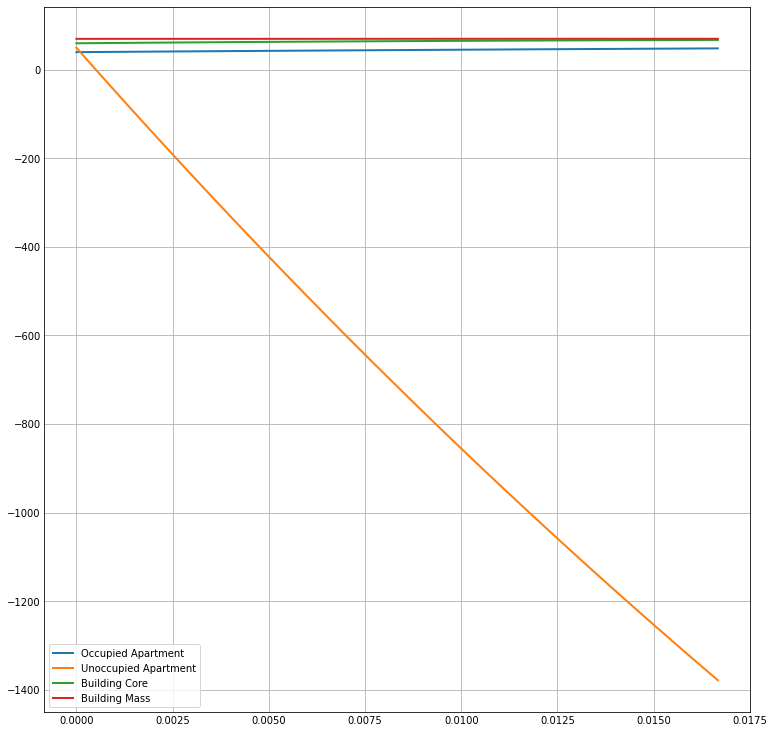

In [1332]:
import matplotlib.pyplot as plt
import scipy 

plt.style.use('_mpl-gallery')

# make data
start = 0
end = 1/60
steps = 100
x = np.linspace(start, end, steps)

DUMP('A')
DUMP('T')



def getTempData (start, end,steps):
       Alist = []
       Ulist = []
       Clist = []
       Mlist = []
       for i in range(steps):
              x = i*(end-start)/steps
              Ttemp = transient_temp_IVP(A,Ft,t0=0,T0=T,t=x)
              
              Alist.append(Ttemp[0])
              Ulist.append(Ttemp[1])
              Clist.append(Ttemp[2])
              Mlist.append(Ttemp[3])
              
       return Alist,Ulist,Clist,Mlist
       
tempA,tempU,tempC,tempM =  getTempData(start,end,steps)


yA = np.array(tempA).reshape(-1,).tolist()
yU = np.array(tempU).reshape(-1,).tolist()
yC = np.array(tempC).reshape(-1,).tolist()
yM = np.array(tempM).reshape(-1,).tolist()
# plot
fig, ax = plt.subplots(figsize=(10,10))



ax.plot(x, yA, linewidth=2.0, label='Occupied Apartment')
ax.plot(x, yU, linewidth=2.0, label='Unoccupied Apartment')
ax.plot(x, yC, linewidth=2.0, label='Building Core')
ax.plot(x, yM, linewidth=2.0, label='Building Mass')

plt.legend()

# ax.set(xlim=(0, 24), xticks=np.arange(1, 8),
#        ylim=(20, 120), yticks=np.arange(1, 8))

plt.show()